In [25]:
%load_ext autoreload
%autoreload 2
%reload_ext lab_black
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


from keras.callbacks import Callback
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    ReduceLROnPlateau,
    EarlyStopping,
    TensorBoard,
)
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v2.keras.layers import BatchNormalization
from tensorflow.python.client import device_lib
from utils import *
from models.unet import *

In [3]:
np.random.seed(8)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7691289069983556366
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4437942395979752024
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Loading images

In [4]:
image_dir_train = "data/training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)
print(f"Loading training images, images loaded: {n_train} ")
imgs_train = np.asarray([load_img(image_dir_train + files[i]) for i in range(n_train)])
gt_dir_train = "data/training/groundtruth/"
print(f"Loading groundtruth images, images loaded: {n_train} ")
gt_imgs_train = np.asarray([load_img(gt_dir_train + files[i]) for i in range(n_train)])

Loading training images, images loaded: 100 
Loading groundtruth images, images loaded: 100 


In [5]:
image_dir_val = "data/validating/images/"
files = os.listdir(image_dir_val)
n_val = len(files)
print(f"Loading validating images, images loaded: {n_val} ")
imgs_val = np.asarray([load_img(image_dir_val + files[i]) for i in range(n_val)])
gt_dir_val = "data/validating/groundtruth/"
print(f"Loading validating groundtruth, images loaded: {n_val} ")
gt_imgs_val = np.asarray([load_img(gt_dir_val + files[i]) for i in range(n_val)])

Loading validating images, images loaded: 20 
Loading validating groundtruth, images loaded: 20 


In [6]:
X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [7]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [8]:
print(X_train.shape)
print(Y_train.shape)
n_train = Y_train.shape[0]

(900, 448, 448, 3)
(900, 448, 448)


In [9]:
X_val, Y_val = imag_rotation_aug(imgs_val, gt_imgs_val)

In [10]:
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

In [11]:
print(X_val.shape)
print(Y_val.shape)
n_val = Y_val.shape[0]

(180, 448, 448, 3)
(180, 448, 448)


In [29]:
# We define parameters of the model
BATCH_SIZE = 150
WINDOW_SIZE = 64
PATCH_SIZE = 16
EPOCHS = 200
STEPS_PER_EPOCH = 100
WIDTH = 448
model = U_NET(
    shape=(WINDOW_SIZE, WINDOW_SIZE, 3),
    BATCH_SIZE=BATCH_SIZE,
    WINDOW_SIZE=WINDOW_SIZE,
    PATCH_SIZE=PATCH_SIZE,
    EPOCHS=EPOCHS,
    STEPS_PER_EPOCH=STEPS_PER_EPOCH,
    WIDTH=WIDTH,
)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 64, 64, 3)    12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 64, 64, 64)   4864        batch_normalization_27[0][0]     
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_63[0][0]                  
____________________________________________________________________________________________

# Train the Model


In [30]:
history = model.train(X_train, Y_train, n_train, X_val, Y_val, n_val)
model.save("best_unet.h5")

 99/100 [============================>.] - ETA: 0s - loss: 0.5656 - accuracy: 0.7581 - recall: 0.7566 - f1: 0.7571
Epoch 00001: val_loss improved from inf to 0.59257, saving model to Unet_batchnorm_validation-001-0.732353.h5
100/100 [==============================] - 34s 339ms/step - loss: 0.5671 - accuracy: 0.7565 - recall: 0.7550 - f1: 0.7555 - val_loss: 0.5926 - val_accuracy: 0.7324 - val_recall: 0.7324 - val_f1: 0.7324


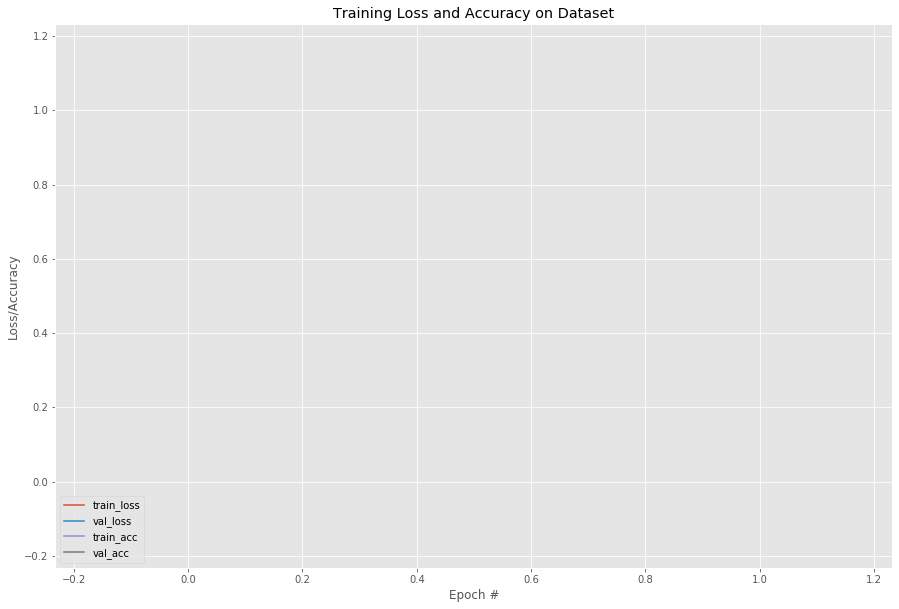

In [31]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"][1:], label="train_loss")
plt.plot(history.history["val_loss"][1:], label="val_loss")
plt.plot(history.history["accuracy"][1:], label="train_acc")
plt.plot(history.history["val_accuracy"][1:], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plots/Unet_batchnorm_validation_ssssss.pdf")
plt.show()

# Generate Submission

In [33]:
model = U_NET(
    shape=(WINDOW_SIZE, WINDOW_SIZE, 3),
    BATCH_SIZE=BATCH_SIZE,
    WINDOW_SIZE=WINDOW_SIZE,
    PATCH_SIZE=PATCH_SIZE,
    EPOCHS=EPOCHS,
    STEPS_PER_EPOCH=STEPS_PER_EPOCH,
    WIDTH=WIDTH,
)
model.load("best_unet.h5")
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

submission_filename = "best_unet.csv"
generate_submission(model, submission_filename, *image_filenames)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 64, 64, 3)    12          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 64, 64, 64)   4864        batch_normalization_36[0][0]     
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_84[0][0]                  
____________________________________________________________________________________________

KeyboardInterrupt: 